In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pyresample
from netCDF4 import Dataset
from ast import literal_eval
from pyproj import Proj, transform 
import xarray as xr
import xesmf as xe

def extract_pixel_coordinates(ULx,Uly,LRx,LRy,shape):
    in_proj  = Proj('+proj=sinu +R=6371007.181 +nadgrids=@null +wktext') #------ Specify input projection
    out_proj = Proj(init='epsg:4326')
    x        = np.linspace(ULx, LRx, shape[0], endpoint=False) + abs((ULx-LRx)/(2*shape[0]))
    y        = np.linspace(ULy, LRy, shape[0], endpoint=False) - abs((ULy-LRy)/(2*shape[0]))
    xx, yy   = np.meshgrid(x,y)
    plon, plat = transform(in_proj, out_proj, xx, yy)
    mlon, mlat = plon[0], np.array([i[0] for i in plat])
    plon       = plon.flatten()
    plat       = plat.flatten()
    return plon, plat, mlon, mlat

/home/kaushal/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/kaushal/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [8]:
fc       = Dataset('MCD43A4/121/MCD43A4.A2018121.h10v05.006.2018130033209.hdf', mode='r')
struct   = getattr(fc, 'StructMetadata.0')
struct1  = struct[struct.find('UpperLeftPointMtrs'): struct.find('LowerRightMtrs')][19:-3]
struct2  = struct[struct.find('LowerRightMtrs')    : struct.find('Projection')    ][15:-3]
ULx, ULy = literal_eval(struct1)
LRx, LRy = literal_eval(struct2)
fc_lon, fc_lat, fc_mlon, fc_mlat  = extract_pixel_coordinates(ULx,ULy,LRx,LRy,(2400,2400))

#lon_curv = fc_lon.reshape(2400,2400)
#lat_curv = fc_lat.reshape(2400,2400)
lon_curv, lat_curv = np.meshgrid(fc_mlon, fc_mlat)

air = fc.variables['Nadir_Reflectance_Band1'][:]
fv  = fc.variables['Nadir_Reflectance_Band1']._FillValue
lat1 = np.linspace(fc_mlat[0], fc_mlat[-1], 1200, endpoint=True)# + abs((fc_mlat[0]-fc_mlat[-1])/(2*200))
lon1 = np.linspace(fc_mlon[0], fc_mlon[-1], 1200, endpoint=True)# - abs((fc_mlon[0]-fc_mlon[-1])/(2*200))

lon2d, lat2d = np.meshgrid(lon1, lat1)

In [4]:
import matplotlib.pyplot as plt
plt.scatter(lon2d,lon2dx)

NameError: name 'lon2dx' is not defined

In [5]:
lon_curv.shape
lat_curv.shape
lon2d.shape
lat2d.shape
air.shape

(2400, 2400)

(2400, 2400)

(1200, 1200)

(1200, 1200)

(2400, 2400)

In [6]:
targ_def = pyresample.geometry.SwathDefinition(lons=lon2d, lats=lat2d)
orig_def = pyresample.geometry.SwathDefinition(lons=lon_curv, lats=lat_curv)

wf = lambda r: 1/r**2
air_idw = pyresample.kd_tree.resample_custom(orig_def, air, targ_def, radius_of_influence=500000, neighbours=4, weight_funcs=wf, fill_value=32767)

/home/kaushal/anaconda3/lib/python3.7/site-packages/pyresample/kd_tree.py:387: UserWarning: Possible more than 4 neighbours within 500000 m for some data points
  (neighbours, radius_of_influence))
/home/kaushal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/kaushal/anaconda3/lib/python3.7/site-packages/pyresample/kd_tree.py:796: RuntimeWarning: invalid value encountered in multiply
  result += weights_tmp * ch_neighbour_list[i]
/home/kaushal/anaconda3/lib/python3.7/site-packages/pyresample/kd_tree.py:801: RuntimeWarning: invalid value encountered in true_divide
  result[result_valid_index] /= norm[result_valid_index]


In [14]:
air_idw.shape

(1200, 1200)

In [15]:
air_idw

masked_array(
  data=[[--, 0.16680001084771126, 0.13699994843942134, ...,
         0.09160023956251809, 0.1379000232795669, --],
        [0.14449998350221788, 0.10660015778800686, 0.12310001027985892,
         ..., 0.14349999660995244, 0.13780006982976412,
         0.13979998832086585],
        [0.16389983841376843, 0.16229994636565276, 0.14160000858524624,
         ..., 0.14600018897372427, 0.14760001149176605,
         0.142699955243836],
        ...,
        [0.09450017059893198, 0.13559953695814747, 0.08330064486101219,
         ..., 0.0060000551045650986, 0.011699963378860966,
         0.0032000612816360198],
        [0.11359996111472934, 0.08890014222617691, 0.17629988769500973,
         ..., 0.010399996098823208, 0.015499983179966292,
         0.014899999241308953],
        [--, 0.20849991918374836, 0.13930000275731233, ...,
         0.009699995609030074, 0.00880000428798966, --]],
  mask=[[ True, False, False, ..., False, False,  True],
        [False, False, False, ..., False,

In [28]:
%matplotlib
plt.imshow(air)

Using matplotlib backend: Qt5Agg


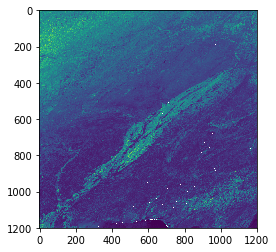

In [16]:
plt.imshow(air_idw)

In [20]:
air_idw[(23,23)]

0.12941393858765807

In [22]:
air_idw[23][23]

0.12941393858765807